SVM for Multi-class Pixel-Wise Image Segmentation of Brain Tumors (meningioma, glioma, pituitary tumor)

In [4]:
import numpy as np
import os
import cv2
import hdf5storage
import sys
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report

Preprocessing Data for SVM

Sample = Pixel
- every pixel is treated separately and hails from the original images

1. Flatten Images and Masks
       - convert each image and mask into a flattened format where each pixel and its label becomes a row
2. Create Feature Arrays (X)
       - X must be a 2D array where each row corresponds to a pixel and each column to a feature of that pixel
       - Even if there is only 1 feature X MUST be a 2D array where 2nd dimension is 1
       - For grayscale images the feature can be intensity value of each pixel -> normalized between 0 and 1
4. Reshape X's array to 2D if X has only 1 feature
5. Create Label Arrays (y)
       - y must be a 1D array where each entry is the label for one pixel
       - i.e. each entry corresponds to a pixel in the original image & contains the classification label derived from the ground truth mask
       - length of y MUST match the number of rows in X
       - If each mask is correctly flattened to a 1D array, it should have shape (262144, ) for a 512x512 image

Meet SVM Input Requirements
- feature data X should be a 2D array where each row represents a sample (pixel) and each column represents a feature 
- If X has a shape of (1000000, 1), it means there are 1,000,000 samples (pixels), and each sample has 1 feature (e.g., grayscale intensity).
- target data y should be a 1D array of labels
    - each element of this array is expected to be a single number: 0 or 1 fr binary classification

# THIS ACC GOT US THE 1D ARRAYS

def load_and_preprocess_data_for_svm(data_dir, image_dimension=512, visualize=False):
    images = []
    masks = []
    files = os.listdir(data_dir)

    for i, file in enumerate(files, start=1):
        try:
            mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0]

            image = cv2.resize(mat_file[2], (image_dimension, image_dimension), interpolation=cv2.INTER_CUBIC)
            mask = cv2.resize(mat_file[4].astype('uint8'), (image_dimension, image_dimension), interpolation=cv2.INTER_NEAREST)
            mask = np.where(mask > 0, 1, 0)

            # Flatten each image to make each pixel an individual sample
            flat_image = image.flatten()
            flat_mask = mask.flatten()

            images.append(flat_image)
            masks.append(flat_mask)

        except Exception as e:
            print(f"Failed to process file {file}: {e}")

    print("\nFinished loading and processing data.")

    # Combine all images and masks into single arrays
    images = np.concatenate(images)
    masks = np.concatenate(masks)

    print(f"Total images shape: {images.shape}")
    print(f"Total masks shape: {masks.shape}")

    return images, masks
data_dir = '/Users/elizabethnemeti/Desktop/data'
image_dimension = 512
images, masks = load_and_preprocess_data_for_svm(data_dir)
print(f"Data shapes - Images: {images.shape}, Masks: {masks.shape}")

Flat Image shape: (262144,)
Flat mask shape: (262144,)
This mask has 262144 pixels


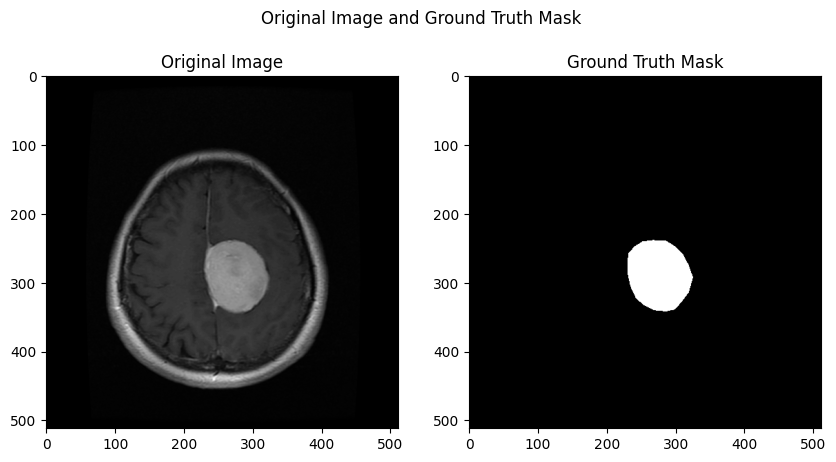

Flat Image shape: (262144,)
Flat mask shape: (262144,)
This mask has 262144 pixels
Flat Image shape: (262144,)
Flat mask shape: (262144,)
This mask has 262144 pixels
Flat Image shape: (262144,)
Flat mask shape: (262144,)
This mask has 262144 pixels
Flat Image shape: (262144,)
Flat mask shape: (262144,)
This mask has 262144 pixels
Flat Image shape: (262144,)
Flat mask shape: (262144,)
This mask has 262144 pixels
Flat Image shape: (262144,)
Flat mask shape: (262144,)
This mask has 262144 pixels
Flat Image shape: (262144,)
Flat mask shape: (262144,)
This mask has 262144 pixels
Flat Image shape: (262144,)
Flat mask shape: (262144,)
This mask has 262144 pixels
Flat Image shape: (262144,)
Flat mask shape: (262144,)
This mask has 262144 pixels
[10/100] images loaded: 10.0 %Flat Image shape: (262144,)
Flat mask shape: (262144,)
This mask has 262144 pixels
Flat Image shape: (262144,)
Flat mask shape: (262144,)
This mask has 262144 pixels
Flat Image shape: (262144,)
Flat mask shape: (262144,)
Th

In [34]:
def load_and_preprocess_data_for_svm(data_dir, image_dimension=512, pca_components=50, visualize=False):
    images = []
    masks = []
    files = os.listdir(data_dir)

    for i, file in enumerate(files, start=1):
        try:
            mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0]

            image = cv2.resize(mat_file[2], dsize=(image_dimension, image_dimension), interpolation=cv2.INTER_CUBIC) # Resize image
            mask = cv2.resize(mat_file[4].astype('uint8'), dsize=(image_dimension, image_dimension), interpolation=cv2.INTER_NEAREST) # Resize mask and ensure binary values
            mask = np.where(mask > 0, 1, 0)  # Ensuring binary values are strictly 0 or 1
            
            # Normalize the resized image
            image = image.astype(np.float32) / 255.0
            flat_image = image.flatten()
            print(f"Flat Image shape: {flat_image.shape}")

            # Flatten the mask
            mask = np.where(mask > 0, 1, 0)  # Ensuring binary values are strictly 0 or 1
            flat_mask = mask.flatten()
            print(f"Flat mask shape: {flat_mask.shape}") # DEBUG CHECK: masks should be 1D
            print(f"This mask has {flat_mask.shape[0]} pixels")  # DEBUG CHECK: pixels should = 512x512 for each image

            # Append processed image and mask to their respective lists
            images.append(flat_image)
            masks.append(flat_mask.astype(bool))

            # DEBUG CHECK: are all file processing and loading correctly
            if i % 10 == 0:
                sys.stdout.write(f'\r[{i}/{len(files)}] images loaded: {i / float(len(files)) * 100:.1f} %')
                sys.stdout.flush()

            if visualize and i == 1:  # DEBUG CHECK: Visual check for the first image and mask
                show_image_and_mask(image, mask)

        except Exception as e:
            print(f"Failed to process file {file}: {e}")

    print("\nFinished loading and processing data.")

    flat_masks_all = np.concatenate(masks) 
    print(f"Shape of all flat_masks combined: {flat_masks_all.shape}")  # DEBUG CHECK: should be (number of images * 262144,)

    return images, flat_masks_all # images_reduced is our SVM input!!!

def show_image_and_mask(image, mask, title="Original Image and Ground Truth Mask"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    plt.suptitle(title)
    plt.show()

data_dir = '/Users/elizabethnemeti/Desktop/data'
image_dimension = 512
images_reduced, flat_masks_all = load_and_preprocess_data_for_svm(data_dir, image_dimension, visualize=True)

SVM Data Splitting

- 80:20 split
- X_train -> features of images for training                        | 2D: (80% of total images, features)
- X_test  -> features of images for testing                         | 2D: (20% of total images, features)
- y_train -> Labels for pixels in training images (flat_masks)      | 1D: (80% of total pixels from all images,)
- y_test  -> Labels for pixels in testing images (flat_masks)       | 1D: (20% of total pixels from all images,)

- X_train and y_train MUST have compatible FIRST dimensions
- AKA each input feature vector from images_reduced must align with a corresponding label vector in flat_masks

In [29]:
# X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42) works for 1D
X_train, X_test, y_train, y_test = train_test_split(images_reduced, flat_masks_all, test_size=0.2, random_state=42)

# DEBUG CHECK
if X_train.shape[0] == y_train.shape[0]:
    print("First dimensions of X_train and y_train match, PROCEED TO TRAINING.")
else:
    print("First dimensions of X_train and y_train do NOT match, AMEND IN PREPROCESSING.")
    
print(f"Shape post-split for X_train: {X_train.shape}, meaning {X_train.shape[0]} pixels will be used as training features.")
print(f"Shape post-split for y_train: {y_train.shape}, meaning {y_train.shape[0]} pixels will be used as training labels.")
print(f"Shape post-split for X_test: {X_test.shape}, meaning {X_test.shape[0]} pixels will be used as testing features.")
print(f"Shape post-split for y_test: {y_test.shape}, meaning {y_test.shape[0]} pixels will be used as testing labels.")

ValueError: Found input variables with inconsistent numbers of samples: [100, 26214400]

SVM Kernel Search and Selection
- compare kernel functions: linear, rbf (gaussian), sigmoid
- compare via training & testing
- measure accuracy, precision, recall, F1 score
- select best parameters via random search (or grid search if it doesn't take too long)

In [21]:
# defining parameters
param_distributions = {
    'C': [0.1, 1, 10, 100],  # regularization parameter
    'kernel': ['linear', 'rbf', 'sigmoid'], # 3 params we're comparing
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'sigmoid'
}

# using random search method
random_search = RandomizedSearchCV(svm.SVC(), param_distributions, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1) # definition
random_search.fit(X_train, y_train) # training

# grabbing best estimator
best_svm = random_search.best_estimator_ # implement sklearn built in funcs

train_predictions = best_svm.predict(X_train) # training predictions
test_predictions = best_svm.predict(X_test)   # testing predictions

# calc performance metrics
train_report = classification_report(y_train, train_predictions, output_dict=True) # metrics for training set
test_report = classification_report(y_test, test_predictions, output_dict=True)    # metrics for testing set

print("Best SVM parameters found by Random Search:", random_search.best_params_)
print("Training Metrics:")
print("Accuracy:", train_report['accuracy'])
print("Precision:", train_report['weighted avg']['precision'])
print("Recall:", train_report['weighted avg']['recall'])
print("F1 Score:", train_report['weighted avg']['f1-score'])

print("Testing Metrics:")
print("Accuracy:", test_report['accuracy'])
print("Precision:", test_report['weighted avg']['precision'])
print("Recall:", test_report['weighted avg']['recall'])
print("F1 Score:", test_report['weighted avg']['f1-score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/svm/_base.py", line 190, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1035, in check_array
    raise ValueError(msg)
ValueError: Expected 2D array, got 1D array instead:
array=[ 376.    0.   21. ...    0. 1594.  647.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/svm/_base.py", line 190, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1035, in check_array
    raise ValueError(msg)
ValueError: Expected 2D array, got 1D array instead:
array=[  39.    0.   57. ...    0. 1594.  647.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/svm/_base.py", line 190, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1035, in check_array
    raise ValueError(msg)
ValueError: Expected 2D array, got 1D array instead:
array=[  39.    0.   57. ...   60.   48. 2664.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.


[CV] END ...................C=1, gamma=scale, kernel=sigmoid; total time=   1.9s
[CV] END ....................C=1, gamma=auto, kernel=sigmoid; total time=   0.6s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   1.8s
[CV] END ....................C=1, gamma=auto, kernel=sigmoid; total time=   0.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   1.8s
[CV] END ....................C=1, gamma=auto, kernel=sigmoid; total time=   0.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   1.8s
[CV] END ....................C=1, gamma=auto, kernel=sigmoid; total time=   0.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END ...................

SVM Training